In [6]:
#Import Libraries

In [2]:
import pandas as pd
import re
import yfinance as yf
from yahoofinancials import YahooFinancials
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from os import listdir
import os
from os.path import isfile, join

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

DATADIR = 'stock_files'
GRAPHDIR = 'stock_graphs'

plt.style.use('seaborn-whitegrid')

In [8]:
#Define Functions

In [57]:
# Math RMSE Function
def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

def enrich_stock_with_smas(stock_pd):
    stock_pd["SMA2"] = stock_pd['Close'].rolling(window=2).mean()
    stock_pd["SMA5"] = stock_pd['Close'].rolling(window=5).mean()
    stock_pd["SMA10"] = stock_pd['Close'].rolling(window=10).mean()
    stock_pd["SMA25"] = stock_pd['Close'].rolling(window=25).mean()
    stock_pd["SMA50"] = stock_pd['Close'].rolling(window=50).mean()
    stock_pd["SMA90"] = stock_pd['Close'].rolling(window=90).mean()
    stock_pd["SMA120"] = stock_pd['Close'].rolling(window=120).mean()
    stock_pd["SMA180"] = stock_pd['Close'].rolling(window=180).mean()
    e_stock_pd = stock_pd
    return e_stock_pd

def enrich_stock_with_bbs(stock_pd):
    #Bollinger Bands
    stock_pd['EWMA'] = stock_pd['Close'].ewm(halflife=0.5, min_periods=20).mean()
    stock_pd['middle_band'] = stock_pd['Close'].rolling(window=20).mean()
    stock_pd['upper_band'] = stock_pd['Close'].rolling(window=20).mean() + stock_pd['Close'].rolling(window=20).std()*2
    stock_pd['lower_band'] = stock_pd['Close'].rolling(window=20).mean() - stock_pd['Close'].rolling(window=20).std()*2
    e_stock_pd = stock_pd
    return e_stock_pd

def get_latest_date(stock_pd):
    dt_latest = stock_pd.iloc[-1:].index[0]
    #dt_latest = stock_pd.iloc[-1:stock_pd.columns.get_loc("Date")]
    return dt_latest

def get_previous_date(dt_latest,nDays):
    dt_previous = dt_latest - timedelta(days=nDays)
    return dt_previous

#usage: save_graph_to_date_dir('TSLA', 'SMA', 90, datetime('2020-04-02'), datetime('2020-07-01') )
def save_graph_to_date_dir(stock_ticker, graph_type, nDays, dt_previous, dt_latest):
    stock_graph_name = stock_ticker+"_"+graph_type+"_"+str(nDays)+"_"+dt_previous.strftime("%Y-%m-%d")+"_"+dt_latest.strftime("%Y-%m-%d")
    dt_str_latest_date = dt_latest.strftime("%Y-%m-%d")
    path_ts = os.path.join(GRAPHDIR,dt_str_latest_date)
    try:
        if not os.path.exists(path_ts):
            os.makedirs(path_ts)
        plt.savefig(path_ts+r'/'+stock_graph_name+r'.png')
        print("Saved Plot as: ["+path_ts+r'/'+stock_graph_name+".png]")
    except:
        print("Error! Could not save Plot as: ["+path_ts+r'/'+stock_graph_name+".png]")

def print_sma_chart_days(stock_ticker, stock_pd, nDays):
    dt_latest = get_latest_date(stock_pd)
    if isinstance(dt_latest, str):
        dt_latest = datetime.strptime(dt_latest,"%Y-%m-%d")
    dt_previous = get_previous_date(dt_latest,nDays)
    plt.figure(figsize=(12,10))
    plt.plot(stock_pd['SMA2'], 'r--', label="SMA2")
    plt.plot(stock_pd['SMA5'], 'y--', label="SMA5")
    plt.plot(stock_pd['SMA10'], 'g--', label="SMA10")
    plt.plot(stock_pd['SMA50'], 'c--', label="SMA50")
    plt.plot(stock_pd['SMA90'], 'm--', label="SMA90")
    plt.plot(stock_pd['SMA180'], 'b--', label="SMA180")
    plt.plot(stock_pd['Close'], label="Close")
    plt.title("["+stock_ticker+"] "+"Stock Price with SMAs from ["+dt_previous.strftime("%Y-%m-%d")+" to "+dt_latest.strftime("%Y-%m-%d")+"] | ["+str(nDays)+"] Days")
    plt.xlabel("Date")
    plt.ylabel("Price [$]")
    plt.ylim(bottom=0)
    plt.xlim([dt_previous, dt_latest])
    plt.legend()
    save_graph_to_date_dir(stock_ticker, 'SMA', nDays, dt_previous, dt_latest)
    plt.show()
    
    
def print_split_chart(stock_ticker, stock_pd, nDaysTotal, nDaysSplit):
    dt_latest = stock_pd.iloc[-1:].index[0]
    if isinstance(dt_latest, str):
        dt_latest = datetime.strptime(dt_latest,"%Y-%m-%d")
    dt_previous = dt_latest - timedelta(days=nDaysTotal)
    plt.figure(figsize=(14,4))
    #plt.plot(stock_pd['SMA2'], 'r--', label="SMA2")
    #plt.plot(stock_pd['SMA5'], 'y--', label="SMA5")
    #plt.plot(stock_pd['SMA10'], 'g--', label="SMA10")
    #plt.plot(stock_pd['SMA50'], 'c--', label="SMA50")
    #plt.plot(stock_pd['SMA90'], 'm--', label="SMA90")
    #plt.plot(stock_pd['SMA180'], 'b--', label="SMA180")
    #plt.figure(figsize=(14,4))
    plt.plot(stock_pd["Train"], 'b--', label="Train")
    plt.plot(stock_pd["Test"],'m--', label="Test")
    plt.legend(["Training Set", "Test Set"])
    #plt.plot(stock_pd['Close'], label="Close")
    plt.title("["+stock_ticker+"] "+"Stock Price with Splits ["+dt_previous.strftime("%Y-%m-%d")+" to "+dt_latest.strftime("%Y-%m-%d")+"] | ["+str(nDaysSplit)+"/"+str(nDaysTotal)+"] Days")
    plt.xlabel("Date")
    plt.ylabel("Price [$]")
    plt.ylim(bottom=0)
    plt.xlim([dt_previous, dt_latest])
    plt.legend()
    save_graph_to_date_dir(stock_ticker, 'SPLIT_'+str(nDaysTotal), nDaysSplit, dt_previous, dt_latest)
    plt.show()
    

def last_stock_date(stock_pd):
    return stock_pd.iloc[-1:].index[0].strftime("%Y-%m-%d")
    
def first_stock_date(stock_pd):
    return stock_pd.iloc[0:].index[0].strftime("%Y-%m-%d")

def save_dataframe_as_csv(stock_pd,stock_ticker):
    dt_str_first_date = stock_pd.iloc[0:].index[0].strftime("%Y-%m-%d")
    dt_str_latest_date = stock_pd.iloc[-1:].index[0].strftime("%Y-%m-%d")
    stock_file_name = stock_ticker+"_"+dt_str_first_date+"_"+dt_str_latest_date+".csv"
    try:
        path_ts = os.path.join(DATADIR,dt_str_latest_date)
        if not os.path.exists(path_ts):
            os.makedirs(path_ts)
        stock_pd.to_csv(path_ts+r'/'+stock_file_name)
        print("Saved DataFrame as: ["+path_ts+r'/'+stock_file_name+"]")
    except:
        print("Error! Could not save Dataframe as: ["+path_ts+r'/'+stock_file_name+"]")

def convert_df_to_pd(stock_df):
    stock_pd = pd.DataFrame(stock_df)
    return stock_pd

def online_process_stock_once(stock_ticker,nDays):
    stock_df = yf.download(stock_ticker)
    stock_pd = convert_df_to_pd(stock_df)
    stock_pd = enrich_stock_with_smas(stock_pd)
    stock_pd = enrich_stock_with_bbs(stock_pd)
    save_dataframe_as_csv(stock_pd,stock_ticker)
    #print(stock_ticker)
    print_sma_chart_days(stock_ticker,stock_pd,nDays)

def get_list_of_files_in_dir(dir_name):
    list_of_files_only = [f for f in listdir(dir_name) if isfile(join(dir_name, f))]
    return list_of_files_only

def read_offline_csv_to_dataframe(dir_name,file_name):
    #path_ts = os.path.join(dir_name,dir_date)
    read_stock_pd = pd.read_csv(dir_name+r'/'+file_name, index_col="Date", parse_dates=["Date"])
    #read_stock_pd = pd.read_csv(path_ts+r'/'+file_name)
    #read_stock_pd['Date'] = pd.to_datetime(read_stock_pd['Date'])
    #read_stock_pd.set_index('Date', inplace=True)
    return read_stock_pd

def get_stock_ticker_name_from_file_name(file_name):
    m = re.search('(^[a-zA-Z]+?)_', file_name)
    if m:
        found = m.group(1)
    return found

def get_stock_dataframe_from_local(dir_name,stock_ticker):
    stock_pd = pd.DataFrame()
    #path_ts = os.path.join(dir_name,dir_date)
    list_of_files = get_list_of_files_in_dir(dir_name)
    for file_name in list_of_files:
        current_stock_title = get_stock_ticker_name_from_file_name(file_name)
        if stock_ticker == current_stock_title:
            stock_pd = read_offline_csv_to_dataframe(dir_name,file_name)
            break
    return stock_pd

def offline_process_stock_once(dir_name,stock_ticker,nDays):
    stock_pd = get_stock_dataframe_from_local(dir_name,stock_ticker)
    print(stock_ticker)
    print_sma_chart_days(stock_ticker,stock_pd,nDays)
    
### Train, Test Split
    
#useage: stock_pd["Train"], stock_pd["Test"] = split(stock_pd, "2020-04-01", "Close")
def split(dataframe, border, col):
    return dataframe.loc[:border,col], dataframe.loc[border:,col]

def edit_stock_split_last_days(stock_pd,nDays,split_column_head_str):
    dt_latest = get_latest_date(stock_pd)
    dt_previous = get_previous_date(dt_latest,nDays)
    dt_str_previous = dt_previous.strftime("%Y-%m-%d")
    stock_pd["Train"], stock_pd["Test"] = split(stock_pd, dt_str_previous, split_column_head_str)
    return stock_pd

In [30]:
### RUN ONLINE UNIT TEST

[*********************100%***********************]  1 of 1 completed
Saved DataFrame as: [stock_files/2020-07-02/TSLA_2010-06-29_2020-07-02.csv]
Saved Plot as: [stock_graphs/2020-07-02/TSLA_SMA_180_2020-01-04_2020-07-02.png]


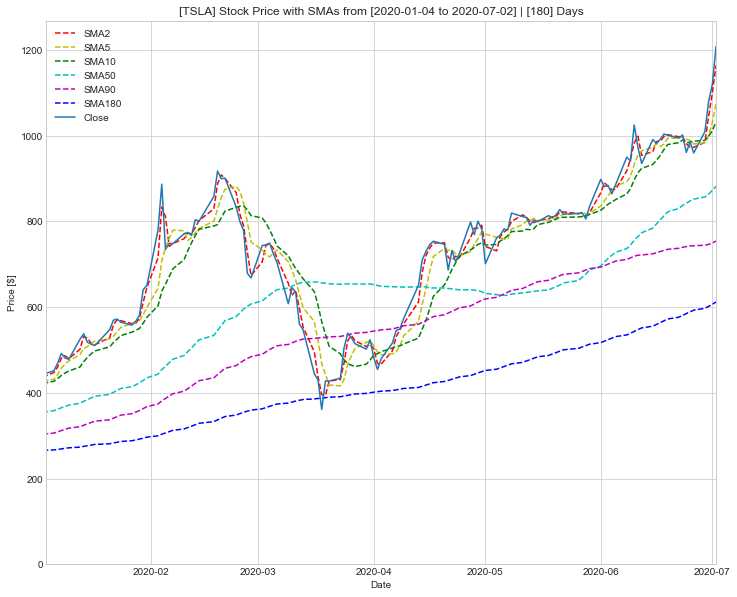

In [60]:
tickers_to_iterate = ['TSLA']
for ticker_name in tickers_to_iterate:
    online_process_stock_once(ticker_name,180)

In [ ]:
### RUN OFFLINE UNIT TEST

In [ ]:
tickers_to_iterate = ['TSLA']
date_folder = '2020-07-02'
for ticker_name in tickers_to_iterate:
    path_ts = os.path.join(DATADIR,date_folder)
    offline_process_stock_once(path_ts,ticker_name,180)

In [ ]:
### ML KERAS EXPERIMENTATION (LOCAL)

Saved Plot as: [stock_graphs/2020-07-02/TSLA_SPLIT_180_45_2020-01-04_2020-07-02.png]


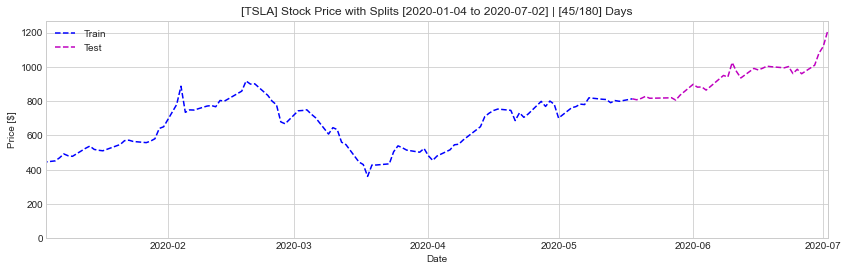

In [58]:
tickers_to_iterate = ['TSLA']
date_folder = '2020-07-02'
for ticker_name in tickers_to_iterate:
    path_ts = os.path.join(DATADIR,date_folder)
    stock_pd = get_stock_dataframe_from_local(path_ts,ticker_name)
    #stock_pd["Train"], stock_pd["Test"] = split(stock_pd, "2020-04-01", "Close")
    nDaysToSplit = 45
    nDaysTotal = 180
    stock_pd = edit_stock_split_last_days(stock_pd,nDaysToSplit,"Close")
    print_split_chart(ticker_name,stock_pd,nDaysTotal,nDaysToSplit)

In [ ]:
### ML KERAS PRODUCTION EXPERIMENTATION (LOCAL)

In [ ]:
tickers_to_iterate = ['TSLA', 'GOOG', 'AMZN', 'AAPL', 'MSFT', 'FB', 'UBER', 'SNAP', 'NVDA', 'AMD', 'GOOGL', 'WORK', 'SHOP', 'CRM', 'ADBE', 'DBX', 'INTC', 'QCOM', 'MU']
date_folder = '2020-07-02'
for ticker_name in tickers_to_iterate:
    path_ts = os.path.join(DATADIR,date_folder)
    stock_pd = get_stock_dataframe_from_local(path_ts,ticker_name)
    #stock_pd["Train"], stock_pd["Test"] = split(stock_pd, "2020-04-01", "Close")
    nDaysToSplit = 45
    nDaysTotal = 180
    stock_pd = edit_stock_split_last_days(stock_pd,nDaysToSplit,"Close")
    print_split_chart(ticker_name,stock_pd,nDaysTotal,nDaysToSplit)

In [ ]:
### PRODUCTION ONLINE EXPERIMENTATION

In [ ]:
tickers_to_iterate = ['TSLA', 'GOOG', 'AMZN', 'AAPL', 'MSFT', 'FB', 'UBER', 'SNAP', 'NVDA', 'AMD', 'GOOGL', 'WORK', 'SHOP', 'CRM', 'ADBE', 'DBX', 'INTC', 'QCOM', 'MU']
for ticker_name in tickers_to_iterate:
    online_process_stock_once(ticker_name,180)

In [ ]:
### PRODUCTION OFFLINE EXPERIMENTATION

In [ ]:
tickers_to_iterate = ['TSLA', 'GOOG', 'AMZN', 'AAPL', 'MSFT', 'FB', 'UBER', 'SNAP', 'NVDA', 'AMD', 'GOOGL', 'WORK', 'SHOP', 'CRM', 'ADBE', 'DBX', 'INTC', 'QCOM', 'MU']
for ticker_name in tickers_to_iterate:
    offline_process_stock_once(DATADIR,ticker_name)

In [ ]:
### Testing

In [ ]:
path_ts = os.path.join(DATADIR,'2020-07-02')
list_of_files = get_list_of_files_in_dir(path_ts)
print(list_of_files)